# SAE features analysis

In [ ]:
import torch
from sae_lens import SAE
from cuml import UMAP
from cuml.metrics import trustworthiness
import numpy as np

import matplotlib.pyplot as plt


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res",
    sae_id = "layer_20/width_16k/average_l0_71",
    device = device,
)

## Comparing $W_\text{enc}$ and $W_\text{dec}$

$W_\text{enc}=W_\text{dec}^\top$ at initialization. Here we want to evaluate how much they differ after training.

In [ ]:
# We want a shape of (n_features, d_model)
W_enc = sae.W_enc.detach().T
W_dec = sae.W_dec.detach()

# Free memory
del sae

print(W_enc.shape)
print(W_dec.shape)

torch.Size([16384, 2304])
torch.Size([16384, 2304])


### UMAP

In [ ]:
umap = UMAP(
    n_components=2,
    n_neighbors=15,
    metric='euclidean'
)

In [ ]:
W_enc_umap = umap.fit_transform(W_enc)
W_dec_umap = umap.fit_transform(W_dec)


Unprocessed data points

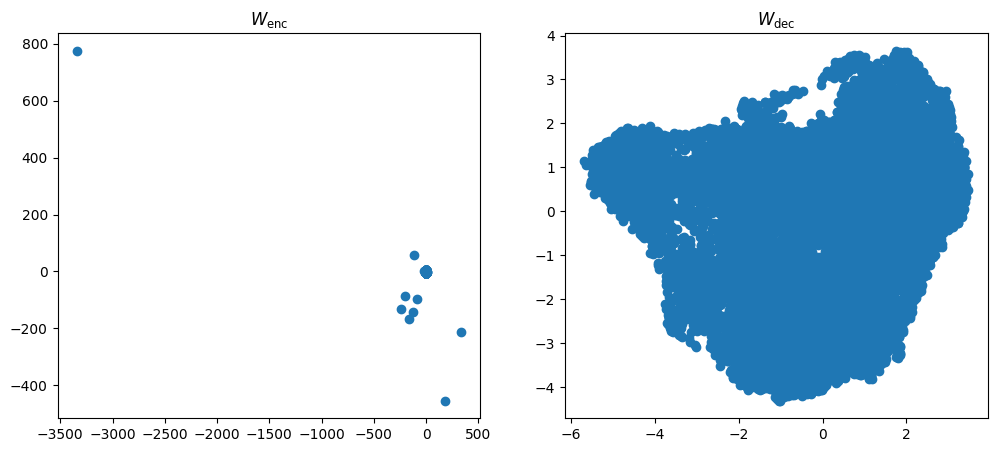

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(W_enc_umap[:, 0].get(), W_enc_umap[:, 1].get(), label="W_enc")
ax1.set_title(r"$W_\text{enc}$")

ax2.scatter(W_dec_umap[:, 0].get(), W_dec_umap[:, 1].get(), label="W_dec")
ax2.set_title(r"$W_\text{dec}$")

plt.show()

Removing outliers and adding color to get a better sense of the data

In [ ]:
# Compute mask to remove outliers
mask = (W_enc_umap[:, 0].get() >= -8) & (W_enc_umap[:, 0].get() <= 8) & (W_enc_umap[:, 1].get() >= -8) & (W_enc_umap[:, 1].get() <= 8)

In [ ]:
def generate_colors(data):
    max_x = max(data[:,0])
    min_x = min(data[:,0])
    max_y = max(data[:,1])
    min_y = min(data[:,1])

    colors = np.empty((0,3))
    for x,y in data:
        x_norm = (x-min_x)/(max_x-min_x)
        y_norm = (y-min_y)/(max_y-min_y)

        r = (1-y_norm)
        g = x_norm
        b = y_norm*(1-x_norm)

        colors = np.append(colors,[(r,g,b)],axis=0)
    
    return colors

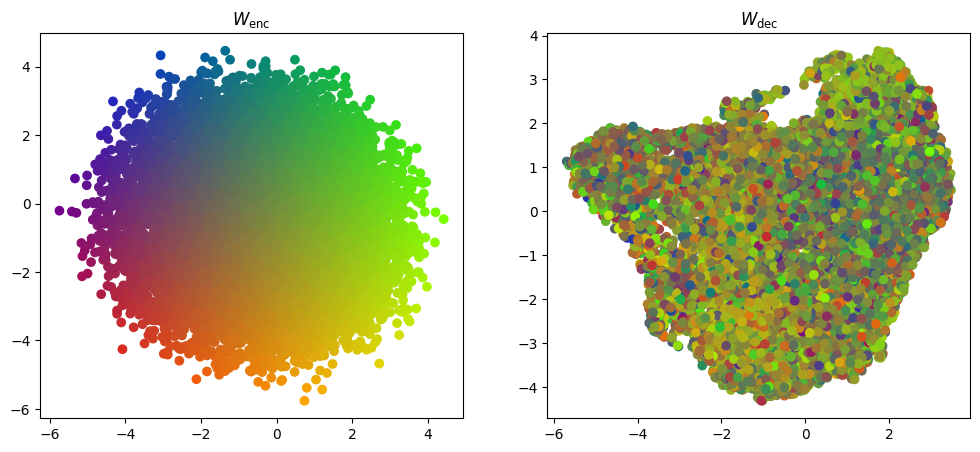

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

colors = generate_colors(W_enc_umap[mask].get())

ax1.scatter(W_enc_umap[mask, 0].get(), W_enc_umap[mask, 1].get(), c=colors)
ax1.set_title(r"$W_\text{enc}$")

ax2.scatter(W_dec_umap[mask, 0].get(), W_dec_umap[mask, 1].get(), c=colors)
ax2.set_title(r"$W_\text{dec}$")

plt.show()

Color helps see that neighborhoods are not preserved.

As a sanity check, let's re-compute UMAP without the outliers.

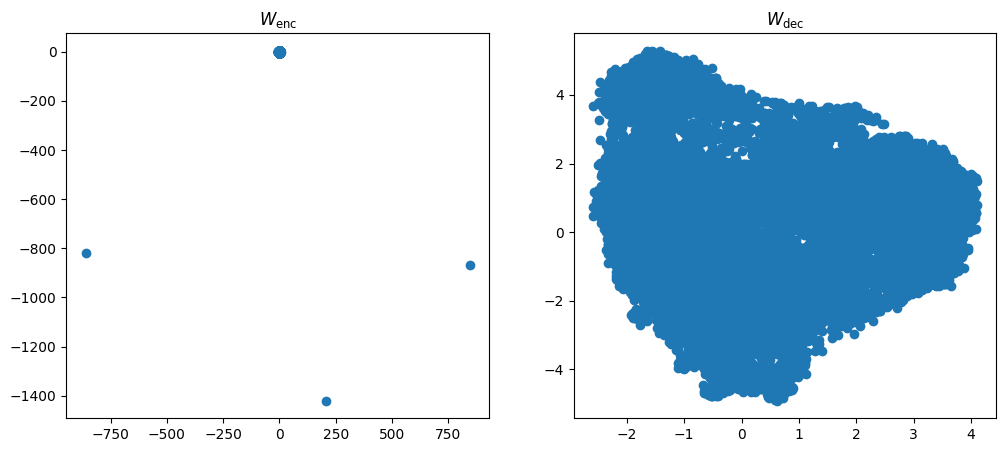

In [ ]:
W_enc_umap_cleaned = umap.fit_transform(W_enc[mask])
W_dec_umap_cleaned = umap.fit_transform(W_dec[mask])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(W_enc_umap_cleaned[:, 0].get(), W_enc_umap_cleaned[:, 1].get(), label="W_enc")
ax1.set_title(r"$W_\text{enc}$")

ax2.scatter(W_dec_umap_cleaned[:, 0].get(), W_dec_umap_cleaned[:, 1].get(), label="W_dec")
ax2.set_title(r"$W_\text{dec}$")

plt.show()


For some reason new outliers appear...

### Trustworthiness

Trustworthiness (TW) is a neighborhood preservation metric that measures how much nearby points in the input space are also nearby in the output space. The obtained score is between 0 and 1 (best). A score of 0.5 is the worst. Formally, for a given neighborhood of size $K$, TW is expressed as
$$
    \textrm{TW}(K) = 1 - \tfrac{2}{NK (2N - 3K - 1)} \sum^N_{i=1}
    \sum_{j \in \mathcal{U}_{K}^{i}} \max(0, (r(i, j) - K)),
$$
where $\mathcal{U}_{K}^{i}$ is the set of $K$ closest neighbors to the $i$ th point in the output space, and $r(i,j)$ is the rank of $j$ in the neighborhood of $i$ in the input space in terms of the Euclidean distance separating them.

In [ ]:
# Smaller subset cause I'm gpu poor :(
subset_size = min(1000, W_enc.shape[0])
idx = torch.randperm(W_enc.shape[0])[:subset_size]

dist_W_enc = torch.cdist(W_enc[idx], W_enc[idx], p=2)
dist_W_dec = torch.cdist(W_dec[idx], W_dec[idx], p=2)

In [ ]:
# Compute trustworthiness for different neighborhood sizes
neighborhood_sizes = [5, 10, 20, 50, 100]
tw_array = []

for k in neighborhood_sizes:
    tw = trustworthiness(dist_W_enc, dist_W_dec, n_neighbors=k)
    tw_array.append(tw)

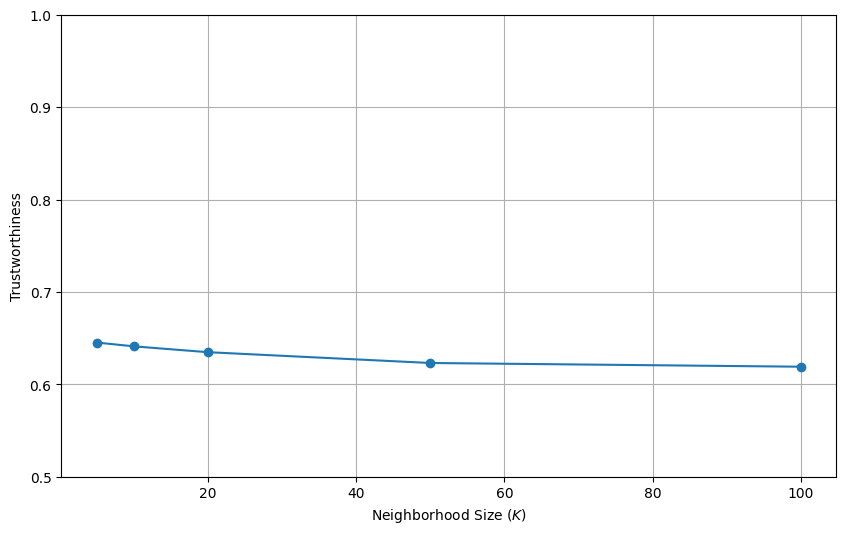

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(neighborhood_sizes, tw_array, marker='o')
plt.xlabel('Neighborhood Size ($K$)')
plt.ylabel('Trustworthiness')
plt.grid(True)
plt.ylim(0.5, 1.0)
plt.show()

Terrible TW, confirming that $W_\text{enc}$ and $W_\text{dec}$ are far from being related.